# 1. Introduction

## Cardiovascular Disease Risk Prediction

This project uses a cardiovascular dataset of 70,000 patients to explore risk factors and build a predictive model for cardiovascular disease (CVD).

**Goals:**
- Clean and preprocess the dataset.
- Explore relationships between BMI, blood pressure, cholesterol, glucose, and CVD.
- Engineer medically meaningful features (e.g. BMI categories, blood pressure stages).
- Train a classification model to predict CVD.

**Tools:** Python (Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn)


# 2. Imports and Data

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import statsmodels

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [64]:
from utils.plotting import plot_hist, plot_bar, barh_percent, plot_boxes, plot_subplots, plot_stacked_counts, plot_heatmap_table, plot_categorical_distribution,plot_categorical_subplot
from utils.evaluation import train_binary_classifier, make_logreg_pipeline
from utils.chategorize import categorize_bp

In [65]:
import config

In [66]:
config.DATASET_NAME.parent / "train.csv"

PosixPath('/Users/lizarabkina/PythonProjects/Cardio/data/train.csv')

In [67]:
df = pd.read_csv(config.DATASET_NAME, sep=";")

In [68]:
original_df = df.copy()
original_df.shape

(70000, 13)

In [69]:
df = original_df.copy() # working dataframe


# 3. Dataset Overview


### 3.1 Dataset Description

In [70]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [71]:
df.shape,df.columns
print(f"There are total of {df.shape[0]} datapoints in this dataset with {(df.shape[1])} columns:")
print(", ".join(df.columns))

There are total of 70000 datapoints in this dataset with 13 columns:
id, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio


### 3.2 Feature Description



| Feature        | Description |
|----------------|-------------|
| **age**        | Age of the patient in days *(convert to years)* |
| **gender**     | 1 = female, 2 = male |
| **height**     | Height in centimeters |
| **weight**     | Weight in kilograms |
| **ap_hi**      | Systolic blood pressure |
| **ap_lo**      | Diastolic blood pressure |
| **cholesterol**| 1 = normal, 2 = above normal, 3 = well above normal |
| **gluc**       | 1 = normal, 2 = above normal, 3 = well above normal |
| **smoke**      | Binary lifestyle feature (0 = no, 1 = yes) |
| **alco**       | Binary lifestyle feature (0 = no, 1 = yes) |
| **active**     | Physical activity (0 = no, 1 = yes) |
| **cardio**     | **Target:** Cardiovascular disease (1 = yes, 0 = no) |


### 3.3 Checking datatypes

In [72]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


### 3.4 Basic Statistics

In [73]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


### 3.5 Handle missing values
In this step, I check for missing values and decide how to treat them.

In [74]:
print("Missing values:\n",df.isnull().sum())

Missing values:
 id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


- No missing values are observed, therefore we continue to the next step of analysis.

### 3.6 Columns removal

In this section I removed "id" column since it didn't bring any value for the analysis

In [75]:
df = df.drop(columns=['id'])

### 3.7 Handling duplicates

In [76]:
print(f"Dataset contains {df.duplicated().sum()} duplicates.")

Dataset contains 24 duplicates.


In this step I will remove duplicates

In [77]:
duplicated = df[df.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['gender', 'height', 'weight'], ascending= False)
duplicated.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
10494,16937,2,170,70.0,120,80,1,1,0,0,0,0
44653,16937,2,170,70.0,120,80,1,1,0,0,0,0
1142,17493,2,169,74.0,120,80,1,1,0,0,1,1
50432,17493,2,169,74.0,120,80,1,1,0,0,1,1
32683,17535,2,165,65.0,120,80,1,1,0,0,1,0


In [78]:
df.drop_duplicates(keep="first", inplace =True)
print(f"After removal of duplicates total of {df.shape[0]} rows and {df.shape[1]} columns remained.")

After removal of duplicates total of 69976 rows and 12 columns remained.


### 3.8 Target balance

In [79]:
print("Target groups (absolute values):",df["cardio"].value_counts())
print("_______________________________")
print("Target groups (%):",df["cardio"].value_counts(normalize=True).mul(100).round(2).astype(str) + "%")

Target groups (absolute values): cardio
0    35004
1    34972
Name: count, dtype: int64
_______________________________
Target groups (%): cardio
0    50.02%
1    49.98%
Name: proportion, dtype: object


- The dataset is equally balanced

# 4. Data cleaning


In this section I clean the raw dataset by:

- converting age from days to years
- handling unrealistic height, weight, and blood pressure values
- removing outliers
- preparing a clean DataFrame (df_clean) for further analysis


In [80]:
df_clean = df.copy()

### 4.1 Convert age and create BMI

In [81]:
# 1. Convert age in days to years
df_clean["age_years"]= df_clean["age"] / 365.25
# 2. Calculate BMI
df_clean["bmi"] = (df_clean["weight"] / (df_clean["height"]/100)**2).round(1)



### 4.2 Outliers exploratory analysis 

In [82]:
num_cols = df_clean.select_dtypes(include=np.number).columns

summary_table_ = df_clean[num_cols].agg(['min', 'max']).T.round(0)
summary_table_

,min,max
age,10798.0,23713.0
gender,1.0,2.0
height,55.0,250.0
weight,10.0,200.0
ap_hi,-150.0,16020.0
ap_lo,-70.0,11000.0
cholesterol,1.0,3.0
gluc,1.0,3.0
smoke,0.0,1.0
alco,0.0,1.0


- Height: remove unrealistic height (the lowest 55 cm) 
- Weight: remove unrealistic weight (the lowest 10 kg)
- ap_hi,ap_lo: can't be negative


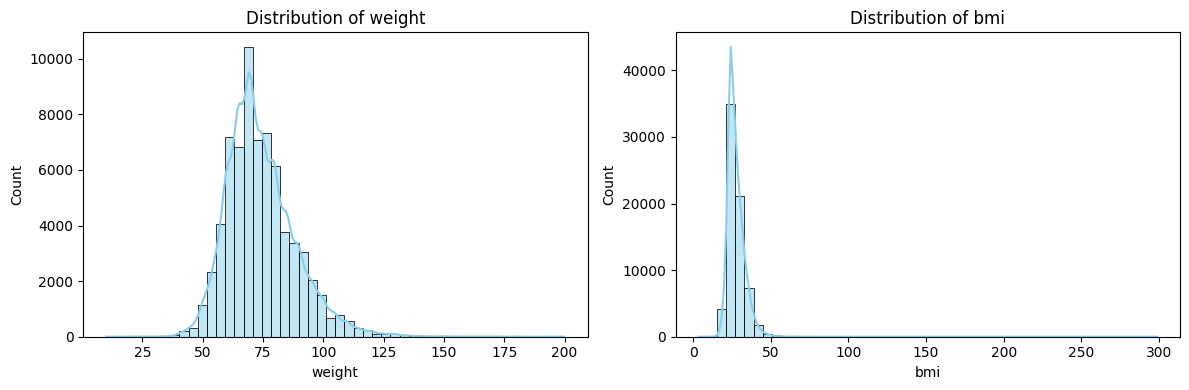

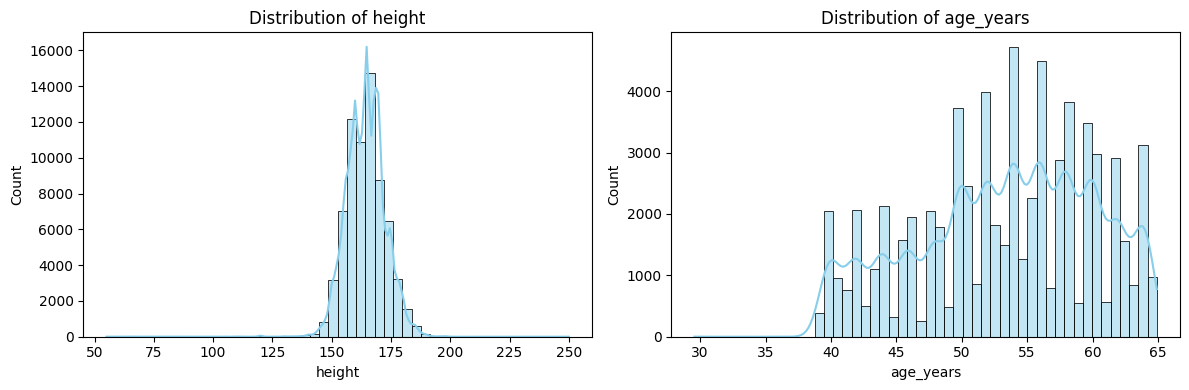

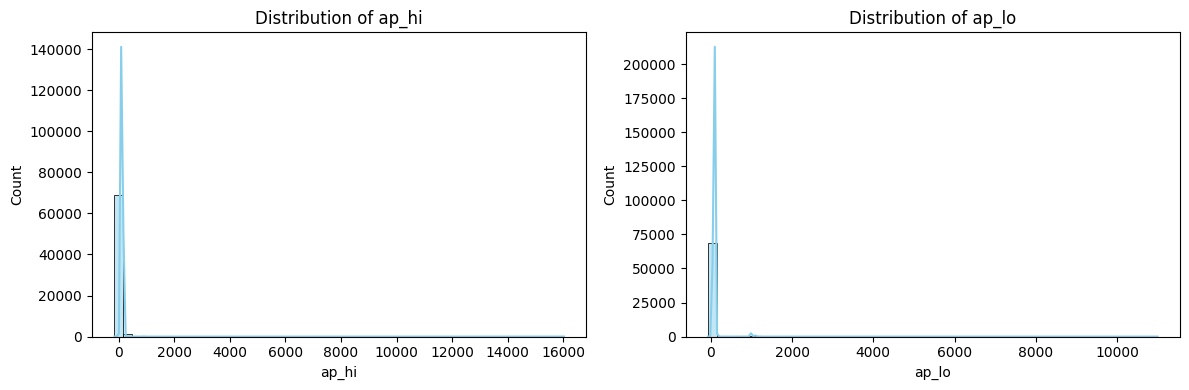

In [83]:
bmi_weight_before = plot_hist(df_clean,["weight","bmi"])
height_age_before = plot_hist(df_clean,["height","age_years"])
ap_hi_lo_before = plot_hist(df,["ap_hi","ap_lo"])

BMI Cut off

In [84]:
# remove BMI <12
pd.set_option('display.max_rows', None)
df_clean[df_clean["bmi"]<12].sort_values(by = "bmi",ascending=False).head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
18559,18140,1,160,30.0,120,80,1,1,0,0,1,1,49.664613,11.7
16906,17272,2,170,31.0,150,90,2,2,0,0,1,1,47.288159,10.7
60699,18875,1,171,29.0,110,70,2,1,0,0,1,1,51.676934,9.9
26806,23284,1,157,23.0,110,80,1,1,0,0,1,0,63.748118,9.3
60188,21855,1,162,21.0,120,80,2,1,0,0,1,1,59.835729,8.0


In [85]:
# remove BMI>60
df_clean[df_clean["bmi"]>60].sort_values(by = "bmi",ascending=False).head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
12770,19594,1,75,168.0,120,80,1,1,1,0,1,1,53.645448,298.7
27384,15292,1,80,178.0,140,90,3,3,0,0,1,1,41.867214,278.1
22723,23386,1,55,81.0,130,90,1,1,0,0,1,1,64.027379,267.8
23913,19074,1,81,156.0,140,90,1,1,0,0,1,0,52.221766,237.8
29157,19088,1,60,69.0,110,70,1,1,0,0,0,0,52.260096,191.7


Height and Age cut off

In [86]:
# remove height <140cm
df_clean[df_clean["height"]<140].sort_values(by = "bmi",ascending=False).head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
12770,19594,1,75,168.0,120,80,1,1,1,0,1,1,53.645448,298.7
27384,15292,1,80,178.0,140,90,3,3,0,0,1,1,41.867214,278.1
22723,23386,1,55,81.0,130,90,1,1,0,0,1,1,64.027379,267.8
23913,19074,1,81,156.0,140,90,1,1,0,0,1,0,52.221766,237.8
29157,19088,1,60,69.0,110,70,1,1,0,0,0,0,52.260096,191.7


Blood pressure values (ap_hi/ap_lo) cut off

In [87]:
# convert ap_hi and ap_lo to floats
df_clean["ap_hi"] = df_clean["ap_hi"].astype(float)
df_clean["ap_lo"] = df_clean["ap_lo"].astype(float)

# Fix extreme types like 1000,1401,etc
df_clean.loc[df_clean["ap_hi"] > 250, "ap_hi"] /= 10
df_clean.loc[df_clean["ap_lo"] > 200, "ap_lo"] /= 10

#Fix reversed values (if diastolic > systolic)
swap_mask = df_clean["ap_lo"] > df_clean["ap_hi"]
df_clean.loc[swap_mask, ["ap_hi", "ap_lo"]] = \
    df_clean.loc[swap_mask, ["ap_lo", "ap_hi"]].to_numpy()



### 4.3 Outliers removal


In [88]:
# Everything is " True"
mask = pd.Series(True, index=df_clean.index)

# 1. Height & BMI filters 
if "height" in df_clean.columns:
    mask &= df_clean["height"].between(140, 200)

if "bmi" in df_clean.columns:
    mask &= df_clean["bmi"].between(12, 60)

# 2. Age filter 
if "age_years" in df_clean.columns:
    mask &= df_clean["age_years"].between(18, 90)

# 3. Blood pressure filters
mask &= df_clean["ap_hi"].between(80, 250)
mask &= df_clean["ap_lo"].between(40, 150)
mask &= df_clean["ap_hi"] >= df_clean["ap_lo"] + 5
mask &= df_clean["ap_hi"] > 0
mask &= df_clean["ap_lo"] > 0

# 4. Weight filters
if "weight" in df_clean.columns:
    mask &= df_clean["weight"].between(40, 200)

# 4. Apply all filters at once
df_clean = df_clean[mask].copy()

df_clean["ap_hi"] = df_clean["ap_hi"].round().astype("Int64")
df_clean["ap_lo"] = df_clean["ap_lo"].round().astype("Int64")


In [89]:
num_cols = df_clean.select_dtypes(include=np.number).columns

summary_table_2 = df_clean[num_cols].agg(['min', 'max']).T.round(0)
summary_table_2

,min,max
age,10798.0,23713.0
gender,1.0,2.0
height,140.0,200.0
weight,40.0,200.0
ap_hi,80.0,240.0
ap_lo,40.0,150.0
cholesterol,1.0,3.0
gluc,1.0,3.0
smoke,0.0,1.0
alco,0.0,1.0


### 4.4 Number of datapoints after cleaning

In [90]:
print(f"Rows before cleaning: {len(original_df)}")
print(f"Rows after filtering: {len(df_clean)}")
print(f"Removed rows: {len(original_df) - len(df_clean)}")

Rows before cleaning: 70000
Rows after filtering: 69471
Removed rows: 529


I applied filters on height, BMI, age, blood pressure and weight.

In total I removed 1411 rows (2% of the dataset), mostly due to implausible blood pressure values, with a smaller number removed due to unrealistic measures.

Explanation of filters:

- Height 140–200 cm & BMI 12–60 & Weight 40-200 kg : adult-plausible bounds to remove unit/entry errors while keeping real extremes.

- BP: physiology-(ap_hi 80–250, ap_lo 40–150, systolic > diastolic)

- Age 18–90: adults


# 5. Exploratory Data Analysis (EDA)

In this section I explore the distribution of key variables after cleaning and how they relate to cardiovascular disease (CVD).

### 5.1 Univariate Distribution


I first look at the distribution of age, BMI, and blood pressure.

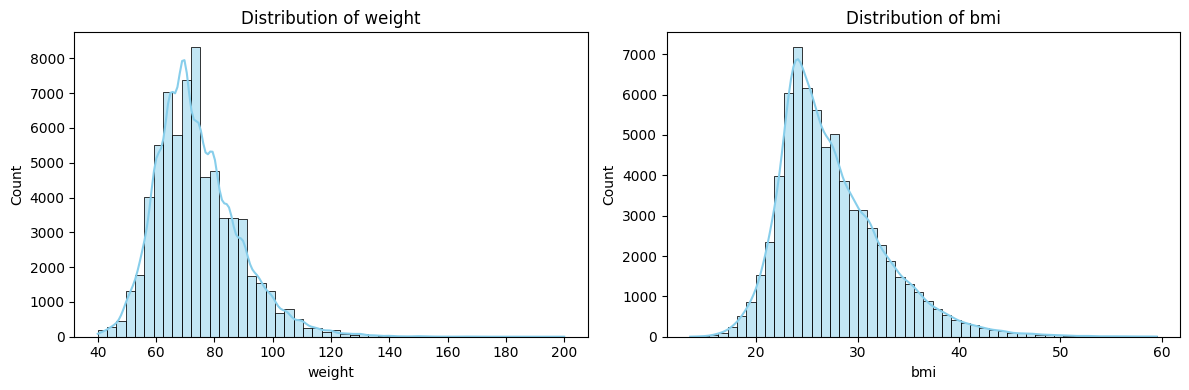

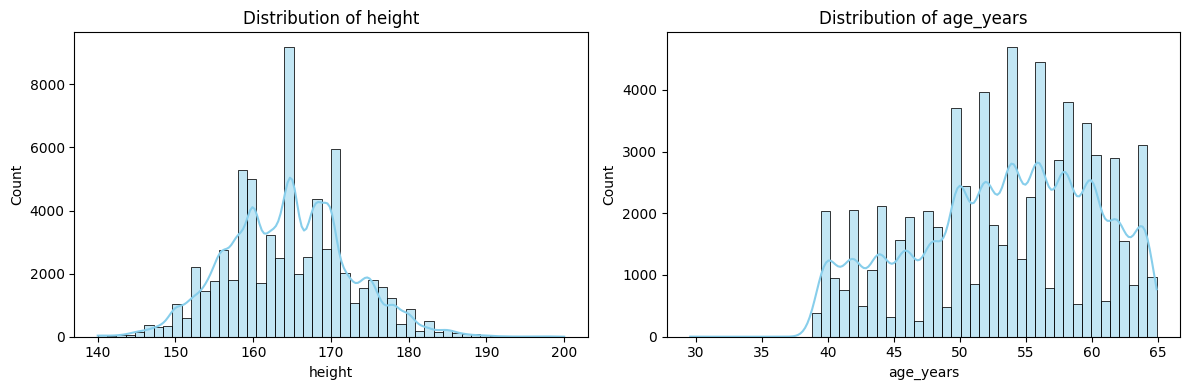

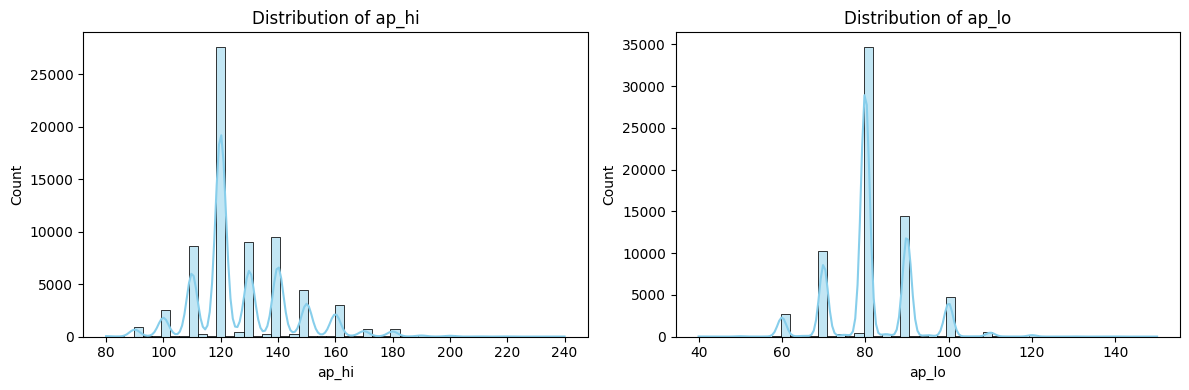

In [91]:
plot_hist(df_clean,["weight","bmi"])
plot_hist(df_clean,["height","age_years"])
plot_hist(df_clean,["ap_hi","ap_lo"])

### 5.2 Distribution of Numeric Features by Cardio Status

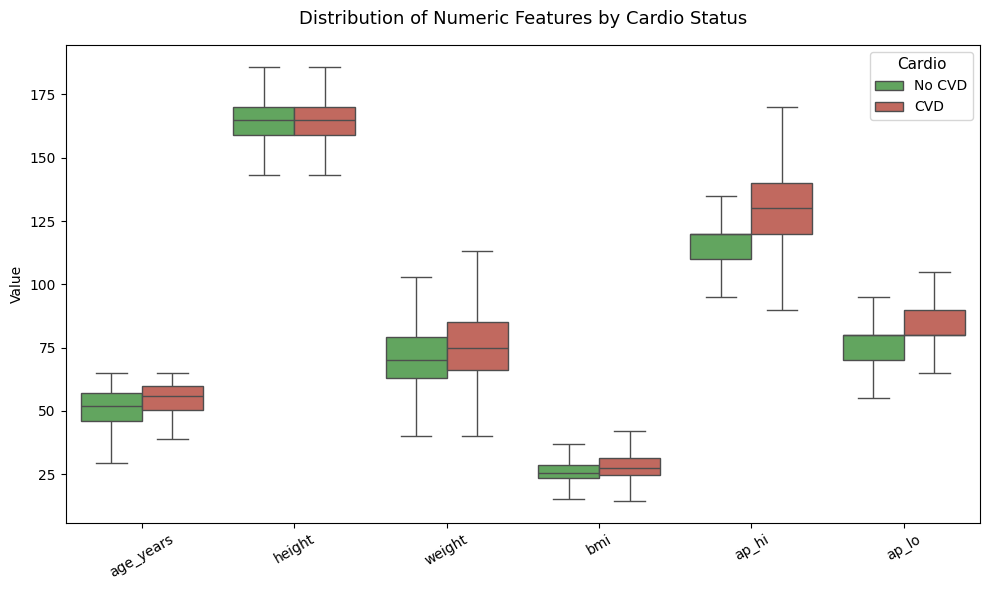

In [92]:
#  Melt the dataset into long format
df_melted = df_clean.melt(
    id_vars='cardio',
    value_vars=config.NUM_VARS,
    var_name='Feature',
    value_name='Value'
)


df_melted['cardio'] = df_melted['cardio'].map({0: 'No CVD', 1: 'CVD'})

# Create the boxplot
plt.figure(figsize=(10,6))
sns.boxplot(
    x='Feature',
    y='Value',
    hue='cardio',
    data=df_melted,
    palette={'No CVD': "#58B153", 'CVD': "#D15C4F"},
    showfliers=False
)

#  Style the plot
plt.title('Distribution of Numeric Features by Cardio Status', fontsize=13, pad=15)
plt.xlabel('')
plt.ylabel('Value')
plt.xticks(rotation=30)
plt.legend(title='Cardio', title_fontsize=11, fontsize=10)
plt.tight_layout()
plt.show()


### 5.3 Distribution by gender

In order to confirm that females and males are labeled correctly in the dataset I computed average heights per gender

In [93]:
df_clean.groupby("gender")["height"].mean().round(2)

gender
1    161.46
2    170.06
Name: height, dtype: float64

We can confirm that Females (162cm) labeled as 1 and Males (170cm) labeled as 2.

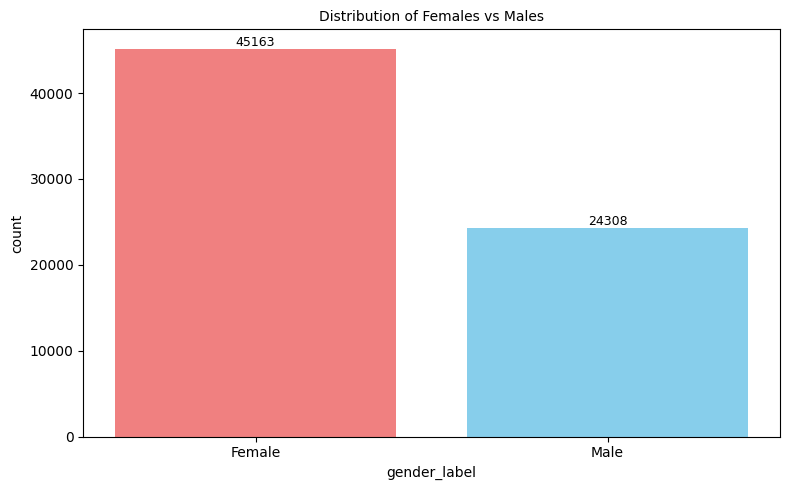

In [94]:
# Mapping gender values (1,2) to Male and Female
df_clean["gender_label"] = df["gender"].replace({1: "Female", 2: "Male"})
# Compute counts of individuals per gender
gender_counts = df_clean["gender_label"].value_counts().rename_axis("gender_label").reset_index(name="count")
# Plot
plot_bar(gender_counts,"gender_label","count",title ="Distribution of Females vs Males", color =["lightcoral","skyblue"])

#### Interpretation
**Note:** In the original dataset, gender is coded as: 1 = Female, 2 = Male. I mapped these values to labels for analysis.

In this dataset : Females - 63-64% and Males - 36-37 %

### 5.4 BMI category



I defined BMI bins using WHO standards:

- Underweight: < 18.5  
- Normal: 18.5–24.9  
- Overweight: 25–29.9  
- Obesity I: 30–34.9  
- Obesity II: 35–39.9  
- Obesity III: ≥ 40  



In [95]:
df_clean["bmi_bin"] = pd.cut(
    df_clean["bmi"],
    bins=config.BMI_BINS,
    labels=config.BMI_LABELS,
    right=False,           
    include_lowest=True
).astype("category").cat.set_categories(config.BMI_LABELS, ordered=True)


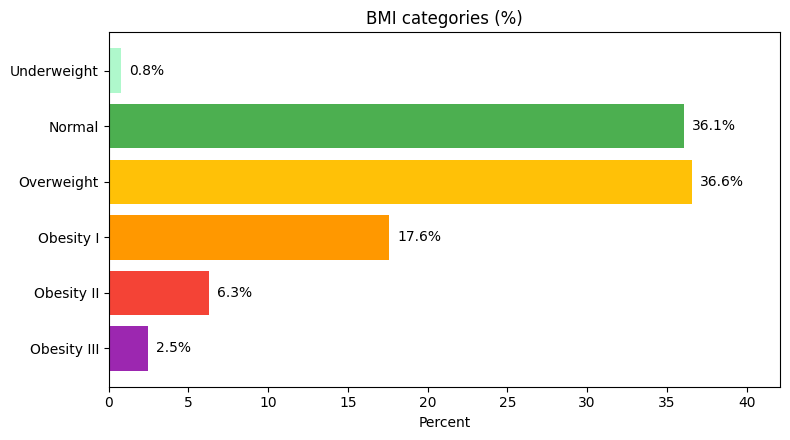

In [96]:
# Define bmi order and bmi colors for further analysis
bmi_counts = (
    df_clean["bmi_bin"]
    .value_counts()
    .rename_axis("bmi_bin")
    .reset_index(name="count")
    .sort_values("bmi_bin")
)

# plot
barh_percent(
    df_clean,
    "bmi_bin",
    order=config.BMI_LABELS[::-1],
    title="BMI categories (%)",
    palette=config.GRADIENT_COLORS[::-1],
)

#### Interpretation 
The BMI distribution in the dataset shows that:
- Normal: 36.1% of individuals fall within this BMI range 
- Overweight: 36.6% are classified as overweight (most common category) 
- Obesity range: 27.3% of the population 
     - Obesity I : 17.6% 
     - Obesity II: 6.3%
     - Obesity III : 2.5 % 
- Underweight: 0.8% of individuals

Overall, nearly 64% of the population have excess body weight, which suggests that this dataset represents a higher-risk clinical population rather than a general, healthier population.

### 5.5 Blood pressure category

#### 5.5.1 Distribution of BP

In [97]:
# create bp categories
df_clean["bp_category"]=df_clean.apply(categorize_bp,axis=1)

bp_counts = (
    df_clean["bp_category"]
    .value_counts()
    .rename_axis("bp_category")
    .reset_index(name="count")
)

bp_counts["bp_category"] = pd.Categorical(bp_counts["bp_category"], categories=config.BP_ORDER, ordered=True)
bp_counts = bp_counts.sort_values("bp_category")


In [98]:
# make bp_category -> categorical variable
df_clean["bp_category"] = pd.Categorical(
    df_clean["bp_category"],
    categories=config.BP_ORDER,
    ordered=True
)

In [99]:
bp_counts.head()

,bp_category,count
2,Normal,9520
3,Elevated,3098
0,Hypertension Stage 1,39764
1,Hypertension Stage 2,16929
4,Hypertensive Crisis,160


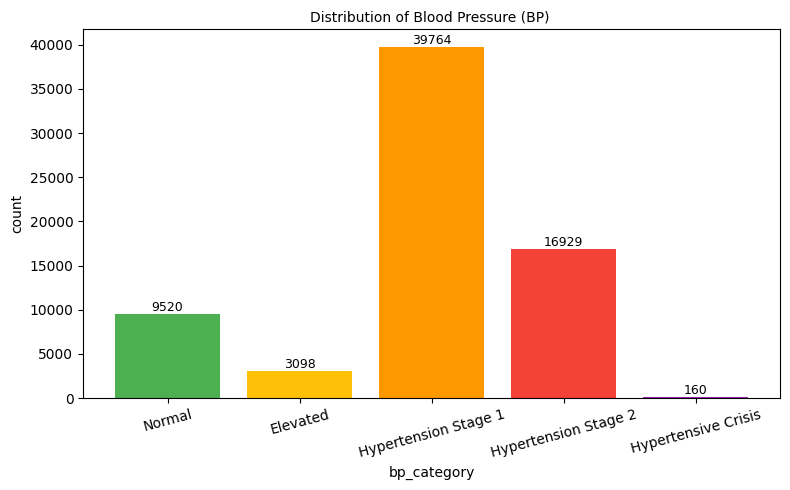

In [100]:
plot_bar(bp_counts,"bp_category","count",title ="Distribution of Blood Pressure (BP) ", color = config.GRADIENT_COLORS[1:],rotation = 15)

#### Interpretation

- Only 13.7% of the population has normal blood pressure.

- 4.5% are classified as elevated.

- A majority, 57.2%, fall into Hypertension Stage 1.

- An additional 24.4% fall into Hypertension Stage 2.

- 0.23% are in Hypertensive Crisis (very severe but rare).

In total, about 82% of the dataset is hypertensive (Stage 1, Stage 2, or Crisis).

#### 5.5.2 Distribution of BP per gender

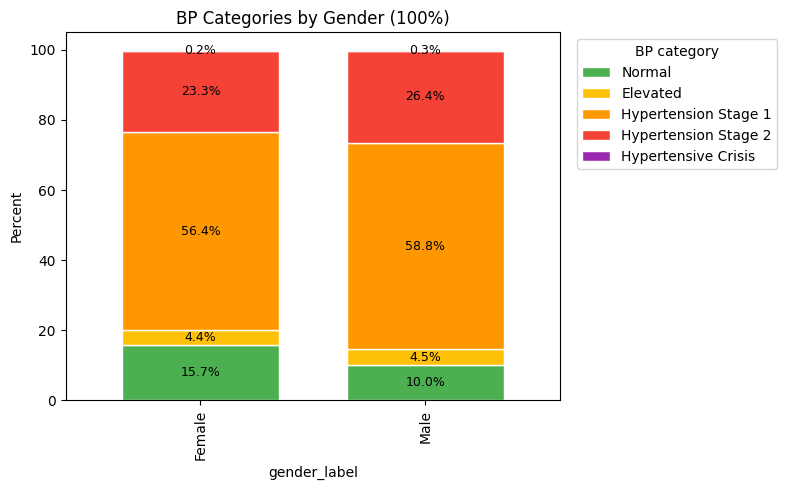

In [101]:
# Crosstab (percentage distribution of BP categories within each gender)
ct = pd.crosstab(df_clean["gender_label"],
                 pd.Categorical(df_clean["bp_category"], categories=config.BP_ORDER, ordered=True),
                 normalize="index") * 100

# plot 
ax = ct.plot(kind="bar", stacked=True, figsize=(8,5), color=config.GRADIENT_COLORS[1:], edgecolor="white", width=0.7)
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="center", fontsize=9, color="black")
plt.ylabel("Percent"); plt.title("BP Categories by Gender (100%)")
plt.legend(title="BP category", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

#### Interpretation

The stacked bar chart shows the percentage distribution of blood pressure categories within each gender.

- **Females** have a higher share of *Normal* blood pressure (**15.7%**) compared with males (**10.0%**).
- **Females** also show slightly lower rates of Hypertension Stage 1 (**56.4%**) and Stage 2 (**23.3%**), compared with males (**58.8%** and **26.4%**, respectively).

**Overall:**  
Men in this dataset show **higher prevalence of hypertension** than women, especially in more severe stages.


### 5.6 Cardio Vascular Disease (CVD) prevalence

#### 5.6.1 CVD prevalence by Blood Pressure

In [102]:
# Labeling individuls based on cardio status
df_clean["cardio_label"]=df_clean["cardio"].map({0:"No CVD",1:"CVD"})

In [103]:
# count of individula per each bp category
df_clean["bp_category"].value_counts().sort_index()

bp_category
Normal                   9520
Elevated                 3098
Hypertension Stage 1    39764
Hypertension Stage 2    16929
Hypertensive Crisis       160
Name: count, dtype: int64

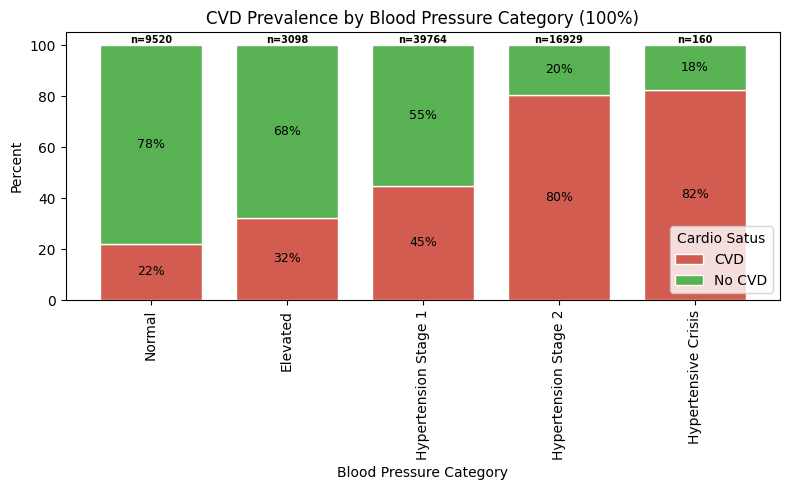

In [104]:
# Crosstab (CVD prevalence by blood pressure category)
ct = pd.crosstab(df_clean["bp_category"], df_clean["cardio_label"], normalize="index") * 100
ax = ct.plot(kind="bar", stacked=True, figsize=(8,5),
             color=["#D15C4F","#58B153"], edgecolor="white", width=0.75,)

for container in ax.containers:
    ax.bar_label(container, fmt="%.0f%%", label_type="center", fontsize=9, color="black")

totals1 = df_clean["bp_category"].value_counts().sort_index()

for i, total in enumerate(totals1):
    ax.text(i, 100,             
            f"n={total}",       
            ha="center", va="bottom", fontsize=7, fontweight="bold")

plt.title("CVD Prevalence by Blood Pressure Category (100%)")
plt.ylabel("Percent"); plt.xlabel("Blood Pressure Category")
plt.legend(title="Cardio Satus"); plt.tight_layout(); plt.show()

##### Interpretation
The relationship between blood pressure and cardiovascular disease (CVD) in the dataset shows a strong increase in CVD prevalence as blood pressure worsens.

- Normal BP: 22% have CVD.

- Elevated BP: CVD prevalence increases to 32%.

- Hypertension Stage 1: nearly half (45%) of individuals have CVD.

- Hypertension Stage 2: 80% of individuals have CVD (Huge jump!)

- Hypertensive Crisis: the highest prevalence, with 82% affected by CVD.


Overall, people with normal or elevated BP are mostly free of CVD, while severe hypertension (Stage 2 and Crisis) is associated with a very high CVD risk.

#### 5.6.2 CVD prevalence by Age

In [105]:
# create age bins
df_clean["age_bin"] = pd.cut(df_clean["age_years"], bins=config.AGE_BINS, labels=config.AGE_NAMES, right=False)

In [106]:
# counts per age bin
df_clean["age_bin"].value_counts().sort_index()

age_bin
18-39     1864
40-49    19627
50-59    35302
60-89    12678
Name: count, dtype: int64

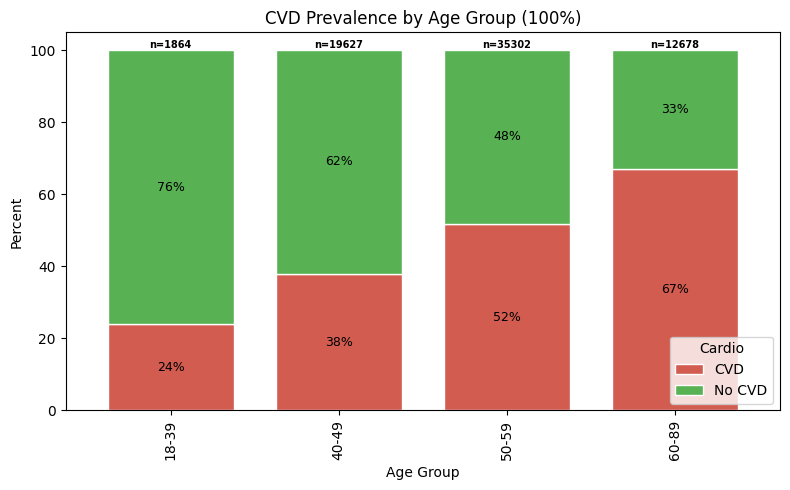

In [107]:
#Crosstab (CVD prevalence by age)
ct = pd.crosstab(df_clean["age_bin"], df_clean["cardio_label"], normalize="index") * 100
ax = ct.plot(kind="bar", stacked=True, figsize=(8,5),
             color=["#D15C4F","#58B153"], edgecolor="white", width=0.75)

for container in ax.containers:
    ax.bar_label(container, fmt="%.0f%%", label_type="center", fontsize=9, color="black")


totals2 = df_clean["age_bin"].value_counts().sort_index()

for i, total in enumerate(totals2):
    ax.text(i, 100,             
            f"n={total}",       
            ha="center", va="bottom", fontsize=7, fontweight="bold")

plt.title("CVD Prevalence by Age Group (100%)")
plt.ylabel("Percent"); plt.xlabel("Age Group")
plt.legend(title="Cardio"); plt.tight_layout(); plt.show()

##### Interpretation

We observe a clear, nearly linear increase in CVD prevalence with age.

- 18–39 group : only 24% have CVD.
- 40–49 group : 38% of individuals have CVD.
- 50–59 group: CVD prevalence increases to 52%.
- 60–69 group: CVD prevalence reaches 67%, the highest of all age groups.

Overall, this pattern reflects the well-known clinical fact that cardiovascular disease risk increases consistently with age due to cumulative vascular stress, arterial stiffness, and long-term exposure to risk factors.

### 5.7 Metabolic & Lifestyle Factors 

#### 5.7.1 Factor labeling

In [108]:
# Assingning labels to all factors
df_clean["cholesterol_label"]=df_clean["cholesterol"].map({1:"Normal", 2:"Above Normal", 3:"Well Above Normal"})
df_clean["glucose_label"]=df_clean["gluc"].map({1:"Normal", 2:"Above Normal", 3:"Well Above Normal"})
df_clean["smoke_label"]=df_clean["smoke"].map({0:"No", 1:"Yes"})
df_clean["alcohol_label"]=df_clean["alco"].map({0:"No", 1:"Yes"})
df_clean["active_label"]=df_clean["active"].map({0:"No", 1:"Yes"})

life_meta_labels =["cholesterol_label", "glucose_label", "smoke_label","alcohol_label","active_label" ]

#### 5.7.2.Distribution of Metabolic Factors

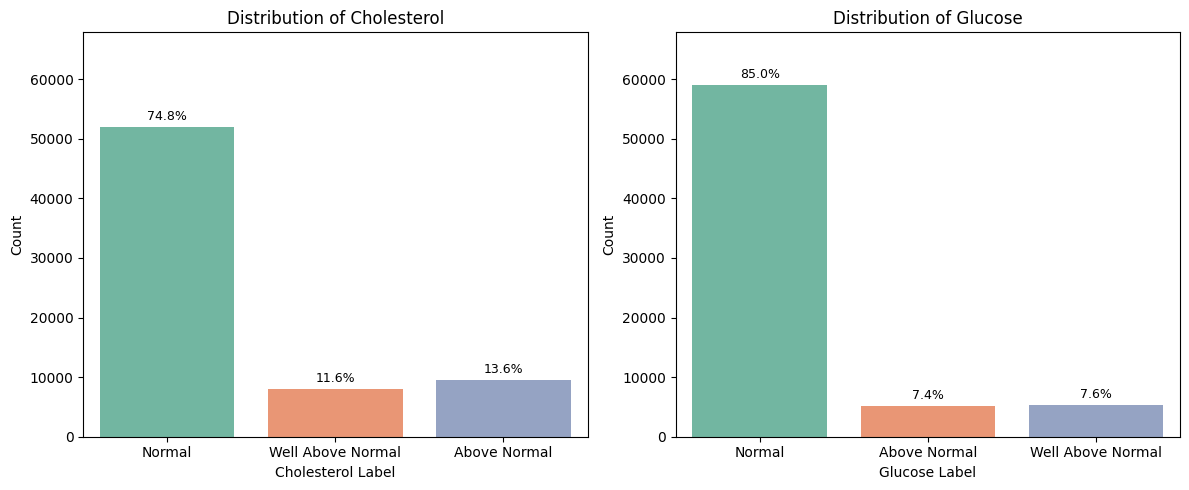

In [109]:
plot_categorical_subplot(df_clean,["cholesterol_label","glucose_label"])


#### 5.7.3.Distribution of Lifestyle Factors

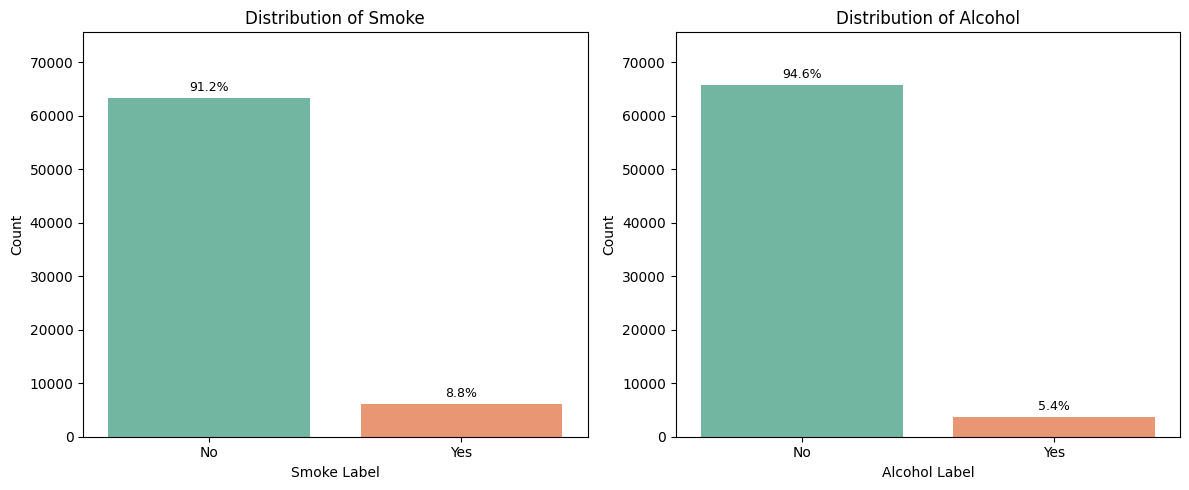

In [110]:
plot_categorical_subplot(df_clean,["smoke_label","alcohol_label"])

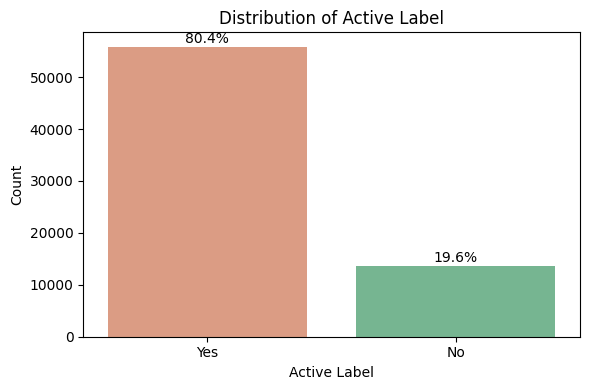

In [111]:
plot_categorical_distribution(df_clean,"active_label",palette = {
    "No": "#6BBF8F",   # green
    "Yes":  "#E99675" ,
})

##### Interpretation

Lifestyle patterns in the dataset show that most individuals have normal cholesterol and glucose levels, do not smoke, and report no regular alcohol use.

Around 80% are physically active, while about 20% report no exercise.

In [112]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,gender_label,bmi_bin,bp_category,cardio_label,age_bin,cholesterol_label,glucose_label,smoke_label,alcohol_label,active_label
0,18393,2,168,62.0,110,80,1,1,0,0,...,Male,Normal,Hypertension Stage 1,No CVD,50-59,Normal,Normal,No,No,Yes
1,20228,1,156,85.0,140,90,3,1,0,0,...,Female,Obesity I,Hypertension Stage 2,CVD,50-59,Well Above Normal,Normal,No,No,Yes
2,18857,1,165,64.0,130,70,3,1,0,0,...,Female,Normal,Hypertension Stage 1,CVD,50-59,Well Above Normal,Normal,No,No,No
3,17623,2,169,82.0,150,100,1,1,0,0,...,Male,Overweight,Hypertension Stage 2,CVD,40-49,Normal,Normal,No,No,Yes
4,17474,1,156,56.0,100,60,1,1,0,0,...,Female,Normal,Normal,No CVD,40-49,Normal,Normal,No,No,No


#### 5.7.4 Categorical Health Variables and CVD Trends

In [113]:
cat_health_var_labels = ["cholesterol_label", "glucose_label", "smoke_label", "alcohol_label", "active_label"]

In [114]:
var_order = {
    "cholesterol_label":config.STANDARD_BIO_INDICATOR_ORDER,
    "glucose_label": config.STANDARD_BIO_INDICATOR_ORDER,
    }

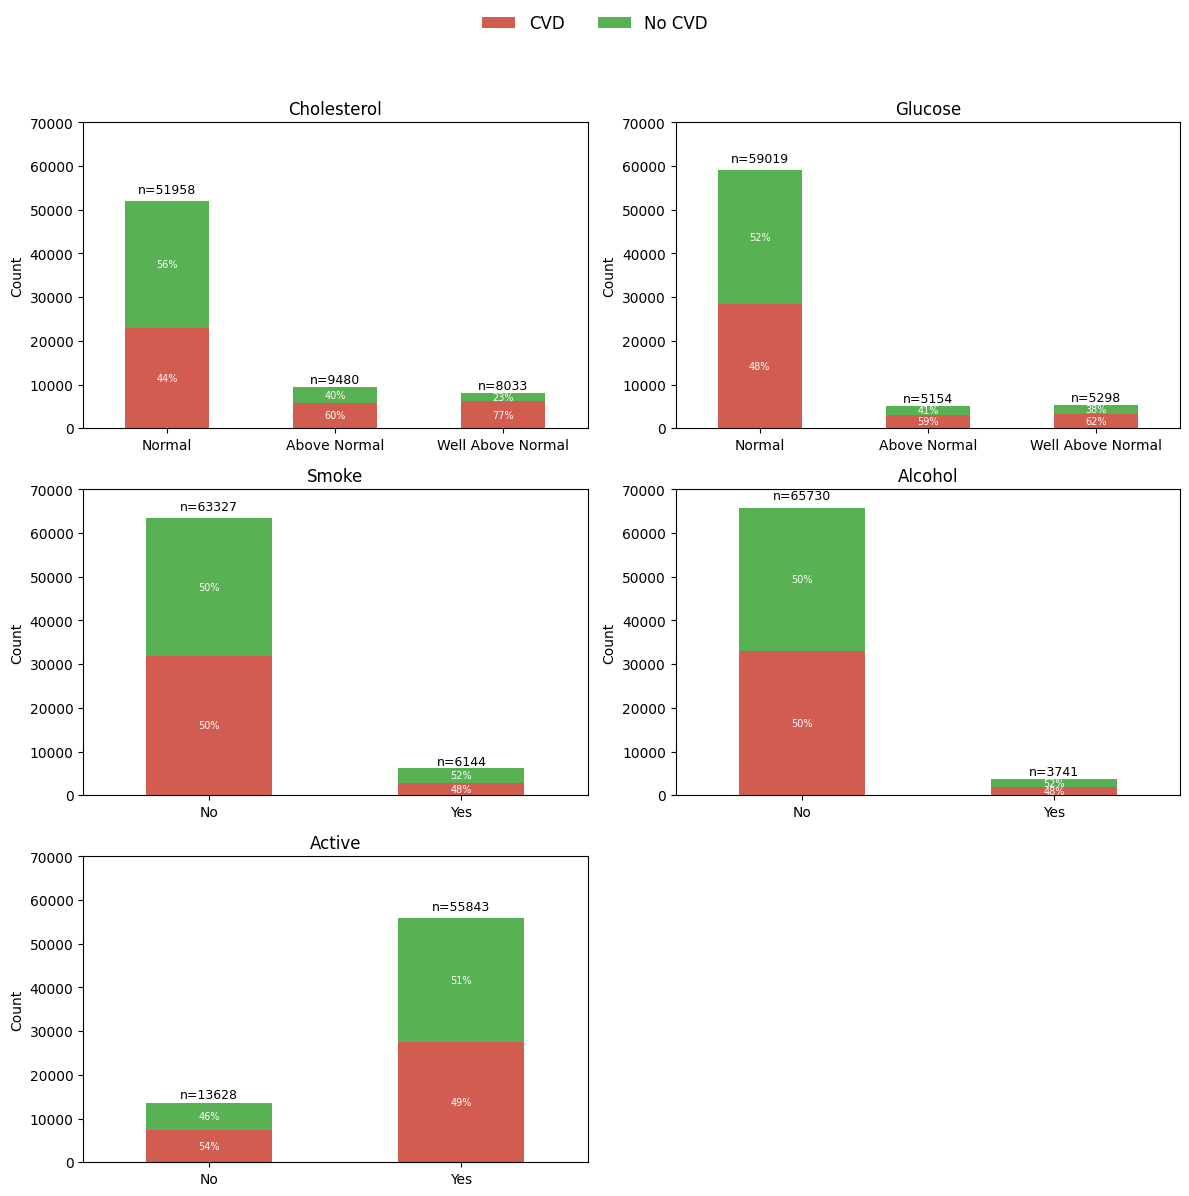

In [115]:
plot_stacked_counts(df_clean,
                    cat_health_var_labels,
                    "cardio_label",
                    var_order=var_order,
                    ncols=2,
                    colors =["#D15C4F","#58B153"],
                    rotation=0,
                    show_percent_inside=True,
                    show_totals_above=True,
                    legend_loc="upper center",
                    ymax =70000)

##### Interpretation

| **Variable**          | **Distribution Insight**    | **CVD Trend**                      | **Interpretation**                                                |
| --------------------- | --------------------------- | ---------------------------------- | ----------------------------------------------------------------- |
| **Cholesterol**       | Majority have normal values | CVD increases from 44% → 60% → 76% | Strong positive association; higher cholesterol = higher CVD risk |
| **Glucose**           | Most are normal             | CVD increases from 48% → 59% → 63% | Higher glucose strongly linked to CVD                             |
| **Smoking**           | ~91% do not smoke           | ~50% CVD in both groups            | No clear effect; small smoker group limits signal                 |
| **Alcohol**           | ~95% do not drink           | ~50% CVD in both groups            | No strong association; very small “Yes” group                     |
| **Physical Activity** | ~80% active                 | 53% (inactive) vs 49% (active)     | Inactivity slightly increases CVD risk                            |


- Cholesterol and glucose show increasing CVD prevalence as values rise — strong predictors.

- Smoking and alcohol show very small or no visible effect, likely due to under-representation.

- Physical inactivity shows a slight increase in CVD prevalence.

- These trends support using cholesterol, glucose, and physical activity as part of the predictive model, with caution regarding smoking and alcohol due to the imbalanced class size.

### 5.8 Correlation heatmap

['height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_years', 'bmi']


<Axes: >

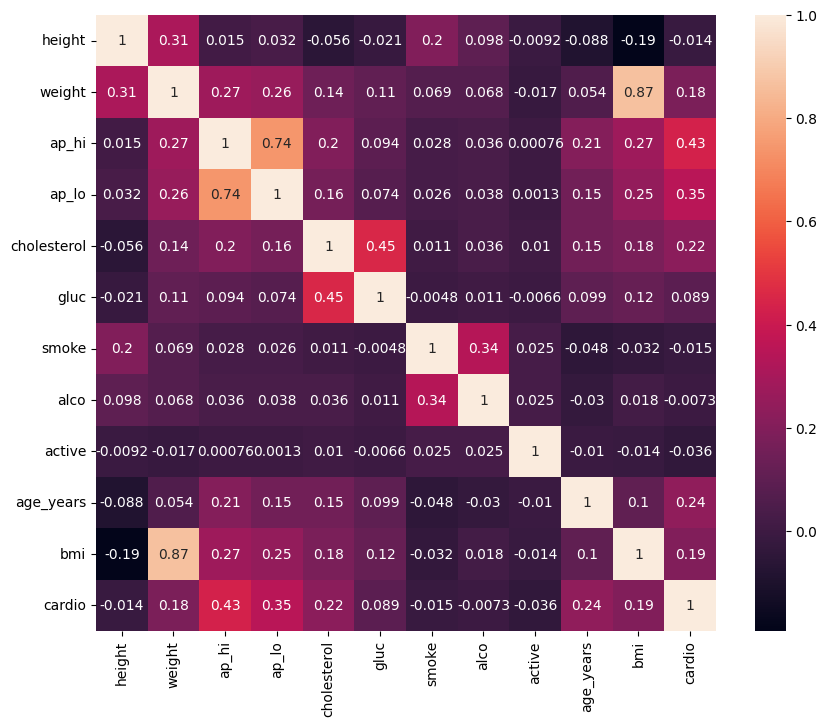

In [116]:
# Remove categorical variables
df_clean_num = df_clean.drop(columns=["age", "gender","gender_label","bp_category","cardio_label","age_bin", "bmi_bin","cholesterol_label","glucose_label","smoke_label","alcohol_label","active_label"])
print(list(df_clean_num.columns))
# move cardio column at the bottom of a heatmap
cols = [col for col in df_clean_num.columns if col!= 'cardio'] + ['cardio']
df_clean_num = df_clean_num[cols]
plt.figure(figsize=(10, 8))
# Spearman correlation
sns.heatmap(df_clean_num.corr(), annot=True)

#### Interpretation

From the last row/column (cardio) we see:
| **Feature**              | **Correlation With CVD** |
| ------------------------ | ------------------------ |
| **Systolic BP (ap_hi)**  | **0.43**                 |
| **Diastolic BP (ap_lo)** | **0.35**                 |
| **Age (age_years)**      | **0.24**                 |
| **Cholesterol**          | **0.22**                 |
| **BMI**                  | **0.19**                 |
| **Weight**               | **0.18**                 |


Systolic and diastolic blood pressure show the strongest positive relationship with CVD status, followed by age and cholesterol levels. 

BMI and weight also demonstrate moderate positive correlations. These variables, therefore, represent the most relevant predictors for modelling cardiovascular disease in this dataset.

### 5.9 High-Risk CVD Groups

#### 5.9.1 Ranking Table

In [117]:
# the group wih the highest risk for CVD among the dataset
risk_table = (
    df_clean
    .groupby(["gender_label", "bmi_bin", "bp_category"],observed=True)
    .agg(
        n=("cardio", "size"),
        cvd_rate=("cardio", "mean")
    )
)

risk_table["cvd_rate"] = risk_table["cvd_rate"] * 100

# keep only groups with enough people (> 50) to avoid tiny groups
risk_table = risk_table.query("n >= 50")

risk_table.sort_values("cvd_rate", ascending=False).head(10)


n   cvd_rate
gender_label bmi_bin     bp_category                          
Male         Obesity II  Hypertension Stage 2   417  85.371703
Female       Obesity III Hypertension Stage 2   681  84.434655
             Obesity II  Hypertension Stage 2  1336  83.682635
Male         Overweight  Hypertension Stage 2  2728  81.891496
Female       Obesity I   Hypertension Stage 2  2737  81.220314
Male         Obesity III Hypertension Stage 2   116  81.034483
             Obesity I   Hypertension Stage 2  1443  80.873181
Female       Overweight  Hypertension Stage 2  3490  79.656160
Male         Normal      Hypertension Stage 2  1689  77.679100
Female       Normal      Hypertension Stage 2  2232  77.240143

#### 5.9.2 Heatmaps per gender

In [118]:
pd.crosstab(df_clean["gender_label"],
            df_clean["bp_category"])

bp_category,Normal,Elevated,Hypertension Stage 1,Hypertension Stage 2,Hypertensive Crisis
gender_label,,,,,
Female,7093,1993,25465,10513,99
Male,2427,1105,14299,6416,61


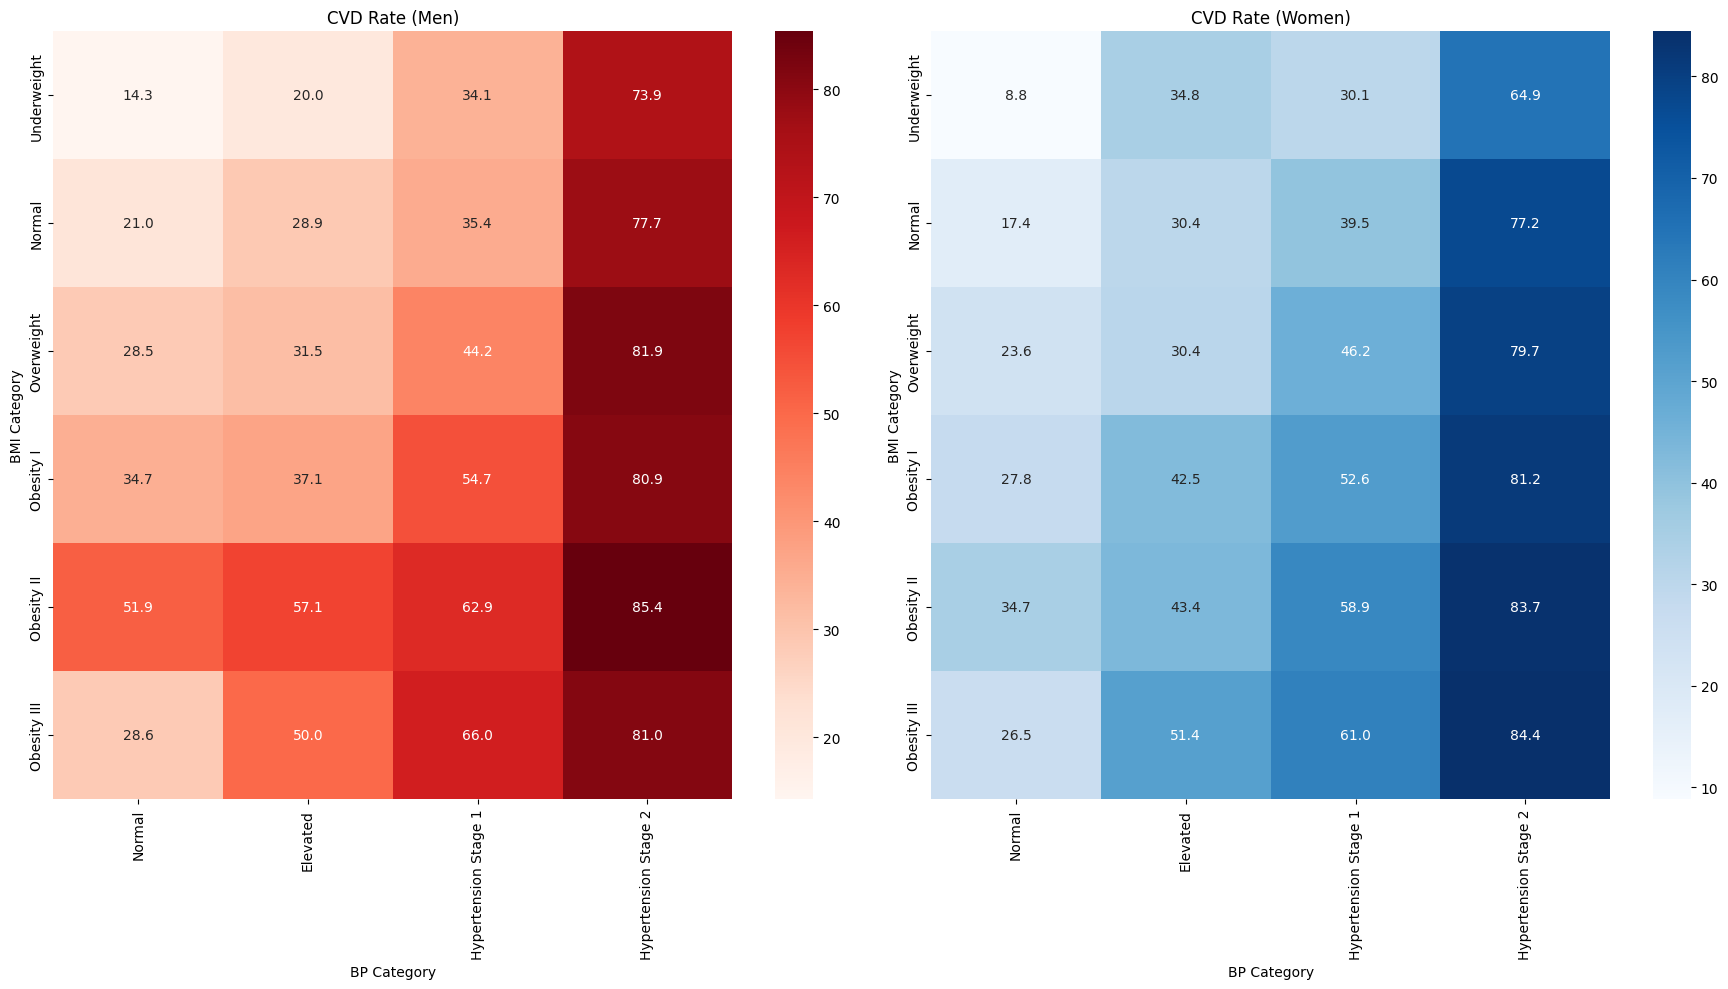

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

df_clean_no_hc = df_clean[df_clean["bp_category"] != "Hypertensive Crisis"].copy()
df_clean_no_hc["bp_category"] = (
    df_clean_no_hc["bp_category"]
    .cat.remove_unused_categories()
)
# male
df_male = df_clean_no_hc[df_clean_no_hc["gender_label"] == "Male"]
male_heatmap = plot_heatmap_table(df_male, ["bmi_bin","bp_category"], "cardio",
              "CVD Rate (Men)", "BP Category", "BMI Category", axes[0], cmap="Reds")

# female
df_female = df_clean_no_hc[df_clean_no_hc["gender_label"] == "Female"]
female_heatmap = plot_heatmap_table(df_female, ["bmi_bin","bp_category"], "cardio",
              "CVD Rate (Women)", "BP Category", "BMI Category", axes[1], cmap="Blues")

plt.tight_layout()
plt.show()

<Axes: xlabel='bp_category', ylabel='bmi_bin'>

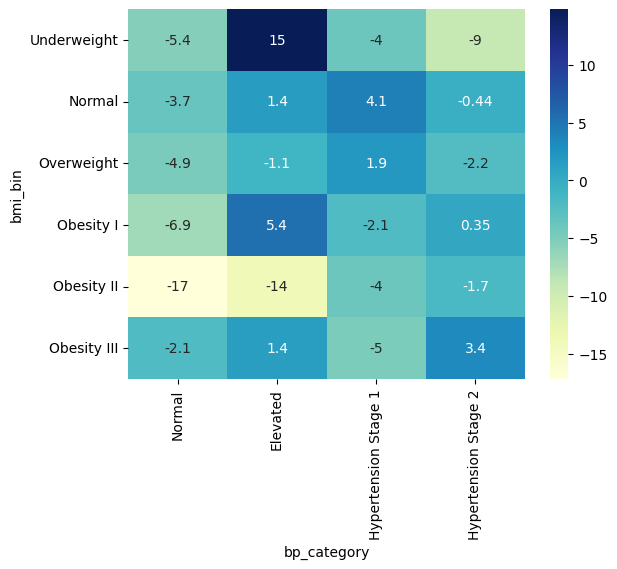

In [120]:
sns.heatmap(female_heatmap - male_heatmap, annot=True, cmap='YlGnBu')

#### Interprepation

**The ranking table** and **heatmaps** reveal a clear pattern: CVD risk increases sharply with both higher BMI and higher blood-pressure stage, and this pattern is consistent across both men and women.

Across all subgroups, the highest CVD prevalence is observed among individuals with:

- Hypertension Stage 2 and
- Obesity (Class I-III).

These combinations consistently produce CVD rates of 80–85%, regardless of gender. Overweight individuals with Stage 2 hypertension also show very high CVD rates (≈80%). Men in general show slightly higher risk in the upper BMI categories, but the gender difference is modest compared to the strong effects of BMI and BP.


The heatmaps confirm this gradient visually:

- Within each BMI group, CVD prevalence increases as BP moves from Normal -> Elevated -> Stage 1 -> Stage 2.

- Within each BP stage, CVD prevalence increases as BMI moves from Normal -> Overweight -> Obesity I -> Obesity II.

- Underweight individuals have the lowest risk, especially women.

Overall, the strongest and most consistent predictors of high cardiovascular risk are **blood-pressure stage** and **BMI category, with Stage 2 hypertension**.

# 6. Statistical analysis

### 6.1. Comparison of Numeric Variables by CVD Status

Null Hypothesis: There is no significant difference in the distribution of the numeric variables between individuals with and without cardiovascular disease (CVD).

Alternative Hypothesis: There is a significant difference in the distribution of the num variables between individuals with and without CVD.

In [121]:

# checking difference between distribution of num variables according to cardio_status
results = []

for col in config.NUM_VARS:
    group0 = df_clean[df_clean['cardio'] == 0][col]
    group1 = df_clean[df_clean['cardio'] == 1][col]

    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')

    median0 = group0.median()
    median1 = group1.median()
    diff = median1 - median0

    results.append({
        'Variable': col.capitalize(),
        'Median (No CVD)': round(median0, 2),
        'Median (CVD)': round(median1, 2),
        'Median Diff': round(diff, 2),
        'U Statistic': round(stat, 2),
        'p-value': round(p, 5)
    })

summary_stat_df = pd.DataFrame(results)
summary_stat_df

,Variable,Median (No CVD),Median (CVD),Median Diff,U Statistic,p-value
0,Age_years,52.03,55.81,3.78,439852325.0,0.00000
1,Height,165.00,165.00,0.00,612711946.5,0.00035
2,Weight,70.00,75.00,5.00,476546686.0,0.00000
3,Bmi,25.50,27.50,2.00,464363463.5,0.00000
4,Ap_hi,120.00,130.00,10.00,296491077.5,0.00000
5,Ap_lo,80.00,80.00,0.00,367760574.0,0.00000


#### Interpretation 

We reject the Null Hypothesis.
There are significant differences between the CVD and non-CVD groups across all key clinical variables, including age, weight, BMI, systolic blood pressure (ap_hi), and diastolic blood pressure (ap_lo).

These results indicate that individuals with CVD consistently show higher median values for these measurements, and all differences are statistically significant (p < 0.00001).

Overall, the statistical tests confirm that CVD and non-CVD individuals differ meaningfully across major clinical features, supporting relevance of these variables for prediction modelling.

Null hypothesis: There is no association between cat variables and cardiovascular disease (CVD) status.

Alternative: There is an association between cat variables and cardiovascular disease (CVD) status.

Individuals with above-normal or well-above-normal cholesterol or glucose levels have a substantially higher chance of having cardiovascular disease (CVD).

In [122]:
# #Association between cat_values and cardio_status
# CAT_VARS = 

# results2 = []

# for col in categorical_vars:
#     contingency = pd.crosstab(df_clean[col], df_clean['cardio'])
#     chi2, p, dof, expected = chi2_contingency(contingency)
#     n = contingency.sum().sum()
#     k, r = contingency.shape
#     cramer_v = np.sqrt((chi2 / n) / (min(k - 1, r - 1)))

#     results2.append({
#         'Variable': col,
#         'Chi2': round(chi2, 2),
#         'p-value': round(p, 5),
#         'Cramér V': round(cramer_v, 3)
#     })

# pd.DataFrame(results2)


Chi-square tests showed that cholesterol and glucose levels differ significantly between individuals with and without CVD (p < 0.001).
However, Cramér’s V indicates that only cholesterol exhibits a moderate practical association (V = 0.22), while glucose and lifestyle factors (smoking, alcohol, activity) show weak or negligible effects.

In [123]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,gender_label,bmi_bin,bp_category,cardio_label,age_bin,cholesterol_label,glucose_label,smoke_label,alcohol_label,active_label
0,18393,2,168,62.0,110,80,1,1,0,0,...,Male,Normal,Hypertension Stage 1,No CVD,50-59,Normal,Normal,No,No,Yes
1,20228,1,156,85.0,140,90,3,1,0,0,...,Female,Obesity I,Hypertension Stage 2,CVD,50-59,Well Above Normal,Normal,No,No,Yes
2,18857,1,165,64.0,130,70,3,1,0,0,...,Female,Normal,Hypertension Stage 1,CVD,50-59,Well Above Normal,Normal,No,No,No
3,17623,2,169,82.0,150,100,1,1,0,0,...,Male,Overweight,Hypertension Stage 2,CVD,40-49,Normal,Normal,No,No,Yes
4,17474,1,156,56.0,100,60,1,1,0,0,...,Female,Normal,Normal,No CVD,40-49,Normal,Normal,No,No,No


### Stratification Matrix

In [124]:
df_clean_summary3 = (
    df_clean
    .groupby(["age_bin", "bp_category"], observed=True)
    .agg(count=("cardio", "size"), cvd_rate=("cardio", "mean"))
    .reset_index()
)

df_clean_summary3.pivot(index="age_bin", columns="bp_category", values="cvd_rate")


bp_category,Normal,Elevated,Hypertension Stage 1,Hypertension Stage 2,Hypertensive Crisis
age_bin,,,,,
18-39,0.083789,0.164948,0.203723,0.750000,0.666667
40-49,0.151292,0.207143,0.336639,0.794094,0.794118
50-59,0.259954,0.352676,0.457830,0.799732,0.829787
60-89,0.440291,0.497872,0.624948,0.829680,0.862069


In [125]:
df_clean_summary3["cvd_rate"] = pd.to_numeric(df_clean_summary3["cvd_rate"], errors="coerce")

In [126]:
df_clean_final=df_clean.copy()

In [127]:
high_bmi = ["Obesity I", "Obesity II", "Obesity III"]
high_bp  = ["Hypertension Stage 1", "Hypertension Stage 2"]

sub = df_clean[
    (df_clean["gender_label"] == "Female") &
    (df_clean["bmi_bin"].isin(high_bmi)) &
    (df_clean["bp_category"].isin(high_bp))
]

n = len(sub)
risk = sub["cardio"].mean() * 100   # % with CVD in this group

print(f"n = {n}")
print(f"CVD risk for women with high BMI and high BP = {risk:.1f}%")


n = 11893
CVD risk for women with high BMI and high BP = 66.0%


In [128]:
high_bmi = ["Obesity I", "Obesity II", "Obesity III"]
high_bp  = ["Hypertension Stage 1", "Hypertension Stage 2"]

sub = df_clean[
    (df_clean["gender_label"] == "Male") &
    (df_clean["bmi_bin"].isin(high_bmi)) &
    (df_clean["bp_category"].isin(high_bp))
]

n = len(sub)
risk = sub["cardio"].mean() * 100   # % with CVD in this group

print(f"n = {n}")
print(f"CVD risk for men with high BMI and high BP = {risk:.1f}%")

n = 4472
CVD risk for men with high BMI and high BP = 67.8%


These differences might reflect a mix of real sex-related biology and sample bias/confounding.
With this EDA alone, we can’t separate the two.

When comparing men and women within the same BMI and BP categories, CVD risk in hypertensive groups (especially Obesity II with hypertension) appears similar between sexes.

However, among individuals with Obesity II but normal or slightly elevated blood pressure, women in this dataset show ~14–17 percentage points higher CVD prevalence than men.

This pattern could be influenced by biological and clinical differences (e.g., body-fat distribution, age/menopause effects, or delayed diagnosis in women), but it may also reflect confounding by age, cholesterol, diabetes and other risk factors, or sampling bias. 

Since our analysis does not adjust for these variables, we interpret this as an exploratory observation rather than proof of a causal biological difference.

Men have higher CVD prevalence than women — until women reach menopause

Here is the clinically accepted pattern across large population studies:

🔹 Ages < 50 (pre-menopausal women)

Men have significantly higher CVD prevalence

Men develop coronary artery disease 7–10 years earlier

Estrogen is cardioprotective → improves HDL, reduces LDL, protects vessels

Men show higher rates of:

Hypertension

Atherosclerosis

Myocardial infarction

Sudden cardiac death

🔹 Ages 50–60+ (post-menopausal women)

As estrogen drops sharply during menopause:

LDL increases

Arterial stiffness increases

Fat redistributes to the abdomen

Blood pressure rises

Women “catch up” and eventually surpass men in CVD prevalence

Women also have worse outcomes after MI and higher mortality

📌 Summary (clinically standard)
Age Group	Higher CVD Prevalence
<50 years	Men
50–60 years	Gap narrows
>60–70 years	Women (post-menopausal increase)
📚 Source: Large epidemiological studies

These findings are consistent across:

Framingham Heart Study

World Health Organization CVD statistics

European Society of Cardiology

American Heart Association (AHA)

All confirm the same trajectory.

In your dataset (70K CVD dataset)

You actually see the same trend:

Men tend to have higher BP, smoke more, drink more → → higher risk younger

Women with CVD tend to be older, with higher BMI, and post-menopausal

In [129]:
import pandas as pd

# choose the variables we want to adjust for
cols = [
    "cardio",        # target: 0/1 CVD
    "gender_label",  # "Male"/"Female"
    "bmi_bin",       # your BMI categories
    "bp_category",   # your BP categories
    "age_years",     # numeric age
    "cholesterol",   # 1 / 2 / 3
    "gluc",          # 1 / 2 / 3
    "smoke",         # 0/1
    "alco",          # 0/1
    "active"         # 0/1
]

df_reg = df_clean[cols].dropna().copy()



Men have about 7% lower odds of CVD than women,
after controlling for:

BMI category

BP category

age

cholesterol

glucose

smoke, alcohol, physical activity

So within this dataset:

For two people with the same age, BMI bin, BP category, cholesterol etc., the man has slightly lower predicted risk of CVD than the woman.

The effect is small compared to BMI, BP and age, but it’s statistically significant.

This actually fits your heatmap story pretty well:
in some cells (like Obesity II + Normal/Elevated BP), women show noticeably higher CVD % than men — and the regression confirms that, even after adjusting for the main risk factors, being female is associated with a bit more CVD in this data.

It doesn’t prove pure biology, but it shows the pattern isn’t only due to age/BP/BMI imbalance.

Odds ratios (vs reference groups):

C(bmi_bin)[T.Obesity II] → OR ≈ 2.50

Obesity II ≈ 2.5× higher odds of CVD vs Underweight (reference), keeping everything else fixed.

C(bp_category)[T.Hypertension Stage 2] → OR ≈ 9.95

Stage 2 hypertension ≈ 10× higher odds of CVD vs Normal BP.

Age: age_years coef = 0.0573 → OR ≈ 1.06 per year

Each extra year ≈ 6% higher odds; +10 years ≈ 1.06¹⁰ ≈ 1.8×.

Compare that to gender:

OR_male ≈ 0.93 → only a 7% difference.

So for your interpretation:

Sex differences exist, but in this dataset, blood pressure, BMI and age are much stronger predictors of CVD than gender itself.

“After adjusting for age, BMI, blood pressure category and other risk factors in a logistic regression model, sex remains a small but statistically significant predictor of CVD: men have about 7% lower odds of CVD than women with similar profiles in this dataset. This supports the idea that sex-related factors (biological and/or clinical) may contribute to the higher CVD rates observed in women in some BMI/BP groups in our heatmaps, although we cannot separate biology from residual confounding or data bias.”

Final conclusion:


The raw heatmap showed that women with Obesity II and normal/elevated BP had 14–17 percentage points higher CVD rates than men.
After adjusting for age, BMI category, BP category, cholesterol, glucose, smoking, alcohol consumption and physical activity, the logistic regression still finds a small but significant sex effect in the same direction: men have ~7% lower odds of CVD than comparable women.
This suggests that the observed difference is not solely due to confounding by age or risk factors. However, the model cannot determine whether this residual difference is biological (e.g., fat distribution, menopause), behavioral (e.g., delayed diagnosis in women), or due to measurement or sampling bias. Therefore, these results should be interpreted as associative, not causal.

Sex differences in CVD risk across BMI and blood pressure categories

When comparing men and women within the same BMI and blood pressure categories, we observe that CVD rates are very similar for individuals with Obesity II and hypertension. However, among individuals with Obesity II but normal or elevated blood pressure, women in this dataset show approximately 14–17 percentage points higher CVD prevalence than men.

To examine whether this pattern is purely due to age or other confounding factors, we fitted a multivariable logistic regression adjusting for age, BMI category, BP category, cholesterol, glucose, smoking, alcohol use and physical activity. After adjustment, sex remains a small but statistically significant predictor of CVD: men have roughly 7% lower odds of CVD than women with comparable profiles (OR = 0.93, p < 0.001).

This suggests that the difference observed in the heatmap is not entirely explained by age or other measured risk factors. Nonetheless, the model cannot determine whether the remaining gap is due to biological differences (e.g., fat distribution, hormonal changes), clinical patterns (e.g., underdiagnosis or later presentation in women), or dataset bias. Therefore, these results should be interpreted as associative rather than causal, but they highlight an interesting sex-specific pattern worth further investigation.

### References literature

“Previous research shows that while the overall association between BMI and CHD is similar in men vs women, sex-specific differences emerge when considering blood pressure and obesity. For example, women appear to incur cardiovascular risk at lower systolic BP thresholds than men (Regitz-Zagrosek 2023). In light of our finding that women with Obesity II and normal/elevated BP have 14–17 percentage points higher CVD prevalence than men, the literature provides plausible biological and clinical mechanisms (e.g., lower BP thresholds, later detection) but does not provide exact estimates for this specific subgroup.”

Then in a footnote or reference list include:

Regensteiner JG, et al. Sex Differences in Cardiovascular Consequences of Obesity, Hypertension, and Diabetes. 2022.

Betai D, et al. Gender Disparities in Cardiovascular Disease and Their Underlying Mechanisms. 2024.

Regitz-Zagrosek V, Gebhard C. Gender medicine: effects of sex and gender on cardiovascular disease manifestation and outcomes. Nature Reviews Cardiology. 2023.

# 6. Feature Engineering

In this section I create additional features that may help the model:

- **Metabolic syndrome-like indicator** combining BMI, BP, cholesterol, and glucose
- **Age × BP stage** interaction
- **Pulse pressure** (ap_hi - ap_lo)



### 6.1 Metabolic Syndrome

In [130]:
# map bp actegories to numeric values
bp_stage_map = {
    "Normal": 0,
    "Elevated": 1,
    "Hypertension Stage 1": 2,
    "Hypertension Stage 2": 3,
    "Hypertensive Crisis": 4
}

df_clean["bp_stage_num"] = df_clean["bp_category"].map(bp_stage_map)

In [131]:
# show how many people belong to each bp category
(
    df_clean[["bp_category", "bp_stage_num"]]
    .value_counts()
    .reset_index(name ="count")
    .sort_values("bp_stage_num")
    .set_index("bp_category")
)

,bp_stage_num,count
bp_category,,
Normal,0,9520
Elevated,1,3098
Hypertension Stage 1,2,39764
Hypertension Stage 2,3,16929
Hypertensive Crisis,4,160


In [132]:
# set rules for metabolic syndrome like indicator ( > 3 out of all parameters)
df_clean["metabolic_syndrome_like"] = (
    (df_clean["bp_stage_num"] >= 2).astype(int) +   # Hypertension Stage 1+
    (df_clean["bmi"] >= 30).astype(int) +           # Obesity
    (df_clean["cholesterol"] >= 2).astype(int) +    # High cholesterol
    (df_clean["gluc"] >= 2).astype(int)             # High glucose
) >= 3

df_clean["metabolic_syndrome_like"] = df_clean["metabolic_syndrome_like"].astype(int)


In [133]:
# Calculate the CVD rate (%) for people with and without metabolic syndrome
cvd_rate_by_metabolic = (
    df_clean
    .groupby("metabolic_syndrome_like")["cardio"]
    .mean() * 100
 
)
round(cvd_rate_by_metabolic,2)

metabolic_syndrome_like
0    46.05
1    71.15
Name: cardio, dtype: float64

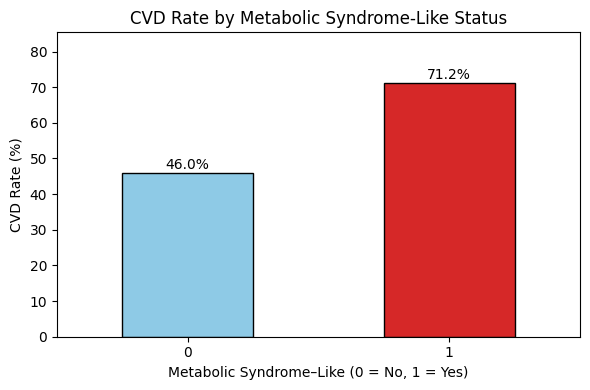

In [134]:
# Plot
plt.figure(figsize=(6,4))

cvd_rate_by_metabolic.plot(
    kind="bar",
    color=["#8ecae6", "#d62828"],
    edgecolor="black"
)

plt.title("CVD Rate by Metabolic Syndrome-Like Status")
plt.xlabel("Metabolic Syndrome–Like (0 = No, 1 = Yes)")
plt.ylabel("CVD Rate (%)")

plt.xticks(rotation=0)
plt.ylim(0, cvd_rate_by_metabolic.max() * 1.2)

# Add labels on top of bars
for i, rate in enumerate(cvd_rate_by_metabolic):
    plt.text(i, rate + 1, f"{rate:.1f}%", ha="center")

plt.tight_layout()
plt.show()


#### Interpretation
- Individuals who meet the criteria for the metabolic syndrome-like feature have a substantially higher cardiovascular disease prevalence.
- CVD rate increases from 45.6% in people without metabolic syndrome-like status to 70.8% in those who exhibit three or more metabolic risk factors.

This represents roughly a 1.5× higher risk and highlights how the clustering of metabolic abnormalities (high BMI, elevated glucose, elevated cholesterol, and high BP stage) significantly amplifies cardiovascular risk.

### Obesity new categories

In [135]:
df_clean_bmi = df_clean.copy()
df_clean_bmi["bmi_int"] =df_clean_bmi['bmi'].astype(int)
cvd_per_bmi = df_clean_bmi.groupby(["gender_label","bmi_int"],observed=True )["cardio"].mean().unstack()
cvd_per_bmi.isnull().any()
cvd_per_bmi

bmi_int,13,14,15,16,17,18,19,20,21,22,...,50,51,52,53,54,55,56,57,58,59
gender_label,,,,,,,,,,,,,,,,,,,,,
Female,NaN,0.285714,0.166667,0.242424,0.213333,0.258278,0.262411,0.317757,0.359119,0.390106,...,0.8125,0.785714,0.703704,0.8,1.000000,0.625,0.714286,0.4,0.714286,1.0
Male,1.0,0.333333,0.222222,0.192308,0.337500,0.282609,0.306180,0.338164,0.374743,0.377725,...,0.7500,1.000000,NaN,1.0,0.333333,0.500,1.000000,0.0,1.000000,1.0


In [136]:
# removing bmi < 14 because 0 to 1 indviduals per group only
# fill NAS using forward fill method
clean_cvd_per_bmi = cvd_per_bmi.iloc[:, 2:].T.ffill().copy()

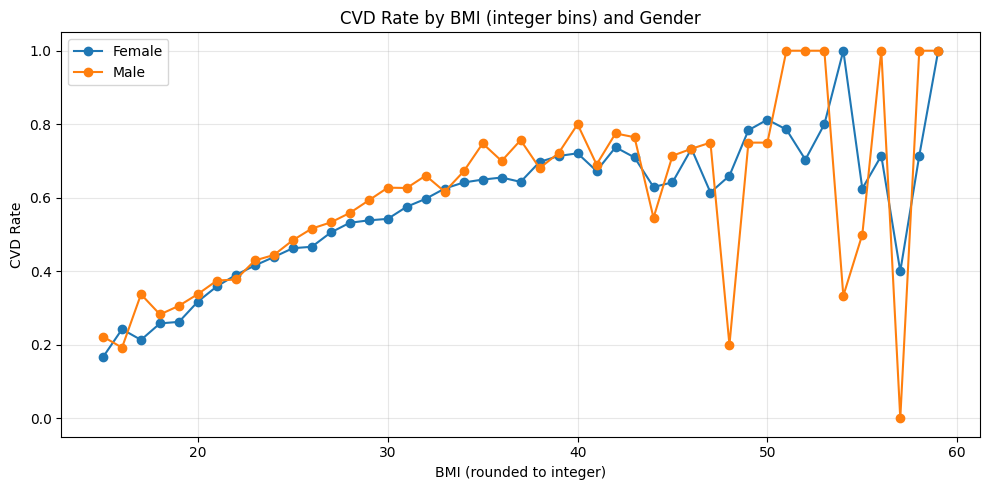

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

for gender in clean_cvd_per_bmi.columns:
    plt.plot(
        clean_cvd_per_bmi.index, 
        clean_cvd_per_bmi[gender], 
        marker='o', 
        label=gender
    )

plt.title("CVD Rate by BMI (integer bins) and Gender")
plt.xlabel("BMI (rounded to integer)")
plt.ylabel("CVD Rate")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [138]:
# 4-BMI rolling mean, centered
cvd_roll = clean_cvd_per_bmi.rolling(
    window=4, center=True, min_periods=1
).mean()

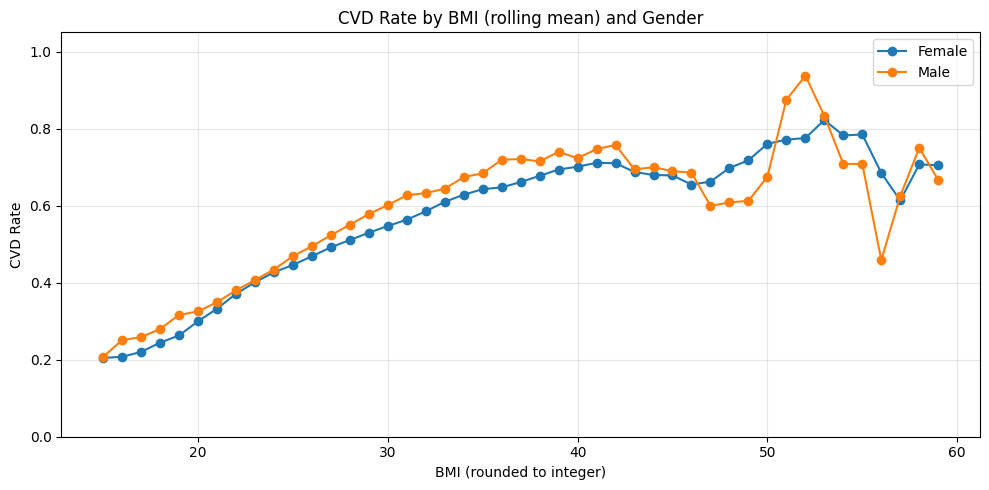

In [139]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for gender in cvd_roll.columns:
    plt.plot(
        cvd_roll.index,
        cvd_roll[gender],
        marker="o",
        label=gender
    )

plt.title("CVD Rate by BMI (rolling mean) and Gender")
plt.xlabel("BMI (rounded to integer)")
plt.ylim(0, 1.05)
plt.ylabel("CVD Rate")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Age * BP

To test if BP  has an effect on CVD prevalence in older people compared to young.

Does high BP increase CVD risk more strongly in older people than in younger people?

In [140]:
# convert categorical values into numercial
df_clean["bp_category_num"] = df_clean["bp_category"].cat.codes
df_clean["age_bp"] = df_clean["age_years"] * df_clean["bp_category_num"]

In [141]:
risk_table = (
    df_clean
    .groupby(["age_bin", "bp_category"],observed=True)["cardio"]
    .mean() * 100
)
print(risk_table)


age_bin  bp_category         
18-39    Normal                   8.378871
         Elevated                16.494845
         Hypertension Stage 1    20.372285
         Hypertension Stage 2    75.000000
         Hypertensive Crisis     66.666667
40-49    Normal                  15.129151
         Elevated                20.714286
         Hypertension Stage 1    33.663917
         Hypertension Stage 2    79.409417
         Hypertensive Crisis     79.411765
50-59    Normal                  25.995435
         Elevated                35.267569
         Hypertension Stage 1    45.782958
         Hypertension Stage 2    79.973193
         Hypertensive Crisis     82.978723
60-89    Normal                  44.029076
         Elevated                49.787234
         Hypertension Stage 1    62.494825
         Hypertension Stage 2    82.968002
         Hypertensive Crisis     86.206897
Name: cardio, dtype: float64


In [142]:
risk_ratio = (
    risk_table.loc[("60-89", "Hypertension Stage 1")] /
    risk_table.loc[("18-39", "Normal")]
)
round(risk_ratio,2)

np.float64(7.46)

Adults aged 60–89 with Hypertension Stage 1 have a CVD prevalence approximately 7.5 times higher than adults aged 18–39 with normal blood pressure.This corresponds to about a 650% higher CVD prevalence.

age + hypertension even at Stage 1 strongly increases cardiovascular risk.

# 7. Models
### Interpretation

- The model achieves an accuracy of XX% and AUC of YY%.
- The recall indicates that the model detects ZZ% of patients with CVD.
- This is acceptable for a baseline medical risk model but could be improved with:
  - more features (e.g. lab tests, medications)
  - non-linear models (e.g. Random Forest, XGBoost)


### 7.1 Baseline Model Training

Here we run the models only with numerical values. Cleaning but no feature engineering

In [143]:
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",  # or None if classes are really 50/50
        solver="saga"
    ))
])


In [144]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=20,   # to avoid overfitting
    n_jobs=-1,
    random_state=42
)

In [145]:
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3
)

In [ ]:
naive_cols = config.NUM_VARS
naive_cols.remove('bmi')
baseline_models = {}
for model_name, model in {"Logistic Regression": log_reg, "Random Forest": rf, "Gradient Boosted Tree": gb}.items():
    print('----------------')
    print(model_name)
    print('----------------')
    baseline_models[model_name] = train_binary_classifier(model=model, df=df_clean[naive_cols + ['cardio']], target="cardio")

----------------
Logistic Regression
----------------
=== Classification Report ===
              precision    recall  f1-score   support

           0      0.699     0.783     0.738      6949
           1      0.753     0.662     0.705      6946

    accuracy                          0.723     13895
   macro avg      0.726     0.723     0.722     13895
weighted avg      0.726     0.723     0.722     13895

=== Metrics ===
{'accuracy': 0.7225620726880173, 'precision': 0.7530702472572458, 'recall': 0.6621076878779153, 'f1': 0.7046655941162951, 'auc': 0.7826907690794978, 'confusion_matrix': [[5441, 1508], [2347, 4599]]}
----------------
Random Forest
----------------
=== Classification Report ===
              precision    recall  f1-score   support

           0      0.706     0.773     0.738      6949
           1      0.750     0.679     0.712      6946

    accuracy                          0.726     13895
   macro avg      0.728     0.726     0.725     13895
weighted avg      0.728 

# 8. Conclusion & Next Steps



**Key findings:**
- Higher BMI and blood pressure stages are strongly associated with CVD.
- Cholesterol and glucose levels above normal increase the risk.
- Lifestyle factors (smoking, alcohol, physical activity) also play a role but are less dominant in this dataset.

**Limitations:**
- Cross-sectional dataset (no time dimension).
- Some variables are coarse (e.g. cholesterol level 1/2/3 only).
- No information on medications or family history.

**Future work:**
- Try tree-based models and compare performance.
- Use calibration curves to check probability estimates.
- Explore interaction effects between features more deeply.
